In [ ]:
import flwr as fl 
import pandas as pd
import os 
import pickle
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tasks as ts
import warnings
import argparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from typing import Dict

import matplotlib.pyplot as plt

from flwr.common import NDArrays



In [65]:
data_1 = pd.read_csv('../IID_df_1.csv')
data_2 = pd.read_csv('../IID_df_2.csv')

In [66]:
scaler = MinMaxScaler()
smote = SMOTE(random_state=422)


In [67]:
test = pd.read_csv('../test_glob.csv')

In [68]:
X_train, y_train = data_1.drop(columns=["Fraud"]), data_1["Fraud"]
X_train_2, y_train_2 = data_2.drop(columns=["Fraud"]), data_2["Fraud"]


X_train_scale = scaler.fit_transform(X_train)
X_train_, y_train_ = smote.fit_resample(X_train_scale, y_train)

X_train_scale_2 = scaler.fit_transform(X_train_2)
X_train_2, y_train_2 = smote.fit_resample(X_train_scale_2, y_train_2)


X_test, y_test = test.drop(columns='Fraud'), test.Fraud 
X_test_scale = scaler.transform(X_test)

model = LogisticRegression(
max_iter=10
)

In [ ]:
# model.fit(X_train_2, y_train_2)
# y_pred_proba = model.predict_proba(X_test_scale)[:, 1]
# y_pred = model.predict(X_test_scale)

# loss = log_loss(y_test, y_pred_proba)
# accuracy = accuracy_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred_proba)
# f1 = f1_score(y_test, y_pred)



c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# (loss, accuracy, roc_auc, f1)

(0.5577015997182881,
 0.6556420233463035,
 0.7645393327211509,
 0.2003012048192771)

In [93]:


def plot_metrics(losses, ROC_AUC, ACCURACY, F1):
   
    rounds = list(range(1, len(losses) + 1))
    
    plt.figure(figsize=(12, 8))
  
    plt.subplot(2, 2, 1)
    plt.plot(rounds, losses, color='blue')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(2, 2, 2)
    plt.plot(rounds, ROC_AUC, color='green')
    plt.title("ROC AUC over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")

    plt.subplot(2, 2, 3)
    plt.plot(rounds, ACCURACY, color='orange')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(2, 2, 4)
    plt.plot(rounds, F1, color='red')
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")

    plt.tight_layout()
    plt.show()



In [88]:
class CustomClient(fl.client.NumPyClient):
    # Инициализируем списки для хранения потерь и метрик
    def __init__(self):
        super().__init__()
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []

    def get_parameters(self, config):
        print('================== INITIAL PARAMS ==================')
        params = ts.get_model_parameters(model)
        print(params)
        return params

    def fit(self, parameters, config):
        ts.set_model_parameters(model, parameters)
        print('============================ PARAMS BEFORE FIT ===========================')
        print(parameters)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train_2, y_train_2)
        
        print(f"Training finished for round {config['server_round']}")
        print('============================= PARAMETERS AFTER FIT ===============================')
        params_1 = ts.get_model_parameters(model)
        print(f'clear: {params_1}')

        # Возвращаем параметры модели после обучения
        return params_1, len(X_train_2), {}

    def evaluate(self, parameters, config):
        print('========================== evaluate PARAMS =============================================')
        ts.set_model_parameters(model, parameters)
        
        y_pred_proba = model.predict_proba(X_test_scale)[:, 1]
        y_pred = model.predict(X_test_scale)
        
        # Вычисляем метрики
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)

        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')

        # Сохраняем метрики в списки
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)
        
        # Возвращаем значения для сервера
        return loss, len(X_test_scale), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}


if __name__ == "__main__":
    N_CLIENTS = 2

    model = LogisticRegression(
        penalty='l2',
        max_iter=2
    )

    ts.set_initial_parameters(model)
    
    # Создаем клиента
    client = CustomClient()

    # Запускаем клиента
    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client
    )

INFO :      
INFO :      Received: train message 066fc041-f880-41ad-98d0-d1d1715cd9a2
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 1aafd8a1-98d6-4628-803f-6cb4a77c442a
INFO :      Sent reply
INFO :      
INFO :      Received: train message df13c60d-467c-445c-be7e-102319e4376e
INFO :      Sent reply


INFO :      
INFO :      Received: evaluate message 26610965-904f-4384-9283-0c9bf425dbdd
INFO :      Sent reply
INFO :      
INFO :      Received: train message 9340b921-2c46-4a7b-b490-70d8f1e7c469
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 85345e7f-6b0e-4958-ace3-3ecd59f6df36
INFO :      Sent reply
INFO :      
INFO :      Received: train message aa21f1c6-3f20-4c43-ae98-518051264919


============================ PARAMS BEFORE FIT ===========================
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]]), array([0.])]
Training finished for round 1
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448,  0.40749495,  0.00291613,
        -0.09700464, -0.9198132 , -0.09665591, -0.41925893,  0.17651717,
        -0.06844895,  0.11924347,  0.00176532,  0.11643901,  0.07970276,
         0.07443131, -0.40144604, -0.08604619, -0.050748  , -0.00462951,
        -0.04802202, -0.30753876, -0.01508538, -0.00421146, -0.1376998 ,
        -0.93749255,  0.        ,  0.08450927]]), array([0.07550136])]
========================== evaluate PARAMS =============================================
accuracy: 0.746757457846952
ROC_A

INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message bac6c6a6-92fd-422e-8dac-3495ae21972f
INFO :      Sent reply
INFO :      
INFO :      Received: train message 23b5f2c3-194e-4944-8bd2-92bb59924f16
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4f757504-df2c-4aea-bce3-63924e81d98e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1a245c92-4455-4646-8d45-985d54418e98
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 1f577a59-9d01-40b5-9594-49f6f298b876


============================ PARAMS BEFORE FIT ===========================
[array([[ 0.00726885, -0.02676929, -0.0124152 , -0.00740414, -0.00106487,
         0.01648753, -0.00227035, -0.02434951,  0.06985325, -0.00042251,
        -0.02142849, -0.17163837, -0.01472919, -0.07719052,  0.05036901,
        -0.01313129,  0.01093845, -0.00780142,  0.00770183, -0.0015033 ,
        -0.00209665, -0.06681908, -0.04062985, -0.02468427,  0.01759678,
        -0.0123305 , -0.02234658, -0.0021464 , -0.01162177, -0.01266843,
        -0.17201494, -0.01833802,  0.02050662]]), array([-0.003859])]
Training finished for round 4
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448,  0.40749495,  0.00291613,
        -0.09700464, -0.9198132 , -0.09665591, -0.41925893,  0.17651717,
        -0.06844895,  0.11924347,  0.00176532,  0.11643901,  0.07970276,
   

INFO :      Sent reply
INFO :      
INFO :      Received: train message 83e6f7d8-7454-4702-aff1-2baca0ce24bc
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message b1751850-2efd-490a-b63e-dd71f404eb3f
INFO :      Sent reply
INFO :      
INFO :      Received: train message a3dba890-6bde-40ec-99c4-94d12bb6651b
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 7f5df366-0993-4be5-b3ed-fd5e6d21d39b
INFO :      Sent reply
INFO :      
INFO :      Received: train message 4023b286-ca29-4abe-b6f8-b32431de1c9a
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 146c9af5-4e7b-4f75-8655-0d7cc758c9f2


accuracy: 0.8550583657587548
ROC_AUC: 0.7619605142332415
f1_score: 0.22260869565217392
============================ PARAMS BEFORE FIT ===========================
[array([[-0.00862189, -0.02776012, -0.01418135, -0.0153341 ,  0.00549387,
         0.03120815, -0.00919881, -0.02567248,  0.08384086, -0.00252172,
        -0.01738532, -0.29127835, -0.03193107, -0.12459984,  0.08329552,
        -0.03035413,  0.01946067, -0.00699063,  0.01019631,  0.01996728,
         0.00379571, -0.10067119, -0.04801898, -0.02097482,  0.02097319,
        -0.01868182, -0.04865394,  0.00311669, -0.01437963, -0.03194627,
        -0.29884655, -0.00824177,  0.03409111]]), array([0.02823194])]
Training finished for round 7
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448,  0.40749495,  0.00291613,
        -0.09700464, -0.9198132 , -0.09665591, -0.41925893,  

INFO :      Sent reply
INFO :      
INFO :      Received: train message e5cc8947-242f-48dd-87f7-b11bcc842dd1
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 4364f250-f0e8-49a9-8586-1e66592ce81f
INFO :      Sent reply
INFO :      
INFO :      Received: train message 78b263dd-f9b7-4c02-90ae-60e2a2c977c9
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 04fcb4f1-9797-4181-adfb-6ffa2a6f28ef
INFO :      Sent reply
INFO :      
INFO :      Received: train message acb7f250-8848-4407-add4-9bfdd25b63a1
INFO :      Sent reply
INFO :      


========================== evaluate PARAMS =============================================
accuracy: 0.8647859922178989
ROC_AUC: 0.7617959902050812
f1_score: 0.22634508348794063
============================ PARAMS BEFORE FIT ===========================
[array([[-0.01108981, -0.02298392, -0.02937764, -0.03097464,  0.00282767,
         0.04157872, -0.00931795, -0.02788684,  0.11333097, -0.00437687,
        -0.02927141, -0.38151609, -0.03172466, -0.18073857,  0.08804629,
        -0.03709083,  0.02244661, -0.0147304 ,  0.0267205 ,  0.01949631,
         0.00976659, -0.13366882, -0.05537443, -0.03352824,  0.00813204,
        -0.033829  , -0.07652633, -0.00531507, -0.0265469 , -0.06894025,
        -0.39761301, -0.01156416,  0.04802055]]), array([0.04400341])]
Training finished for round 10
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.0272044

INFO :      Received: evaluate message 9529ce56-dd15-4c9d-9ea1-3de3dce523c8
INFO :      Sent reply
INFO :      
INFO :      Received: train message 7c45905a-65e1-4346-a5ce-df2b4cc46867
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 8a534710-32d1-4677-a40b-1788c37688d2
INFO :      Sent reply
INFO :      
INFO :      Received: train message 4fd2bf84-8cb8-4ba0-bcf7-78979cc550c5
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 6bb27e45-da17-4029-af46-e4322afd4b1f
INFO :      Sent reply
INFO :      
INFO :      Received: train message 44d69c6a-c1fe-4e03-b971-608bdb6b1c3e
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0acc0eb9-825f-4452-831d-06fab20f93c2
INFO :      Sent reply


========================== evaluate PARAMS =============================================
accuracy: 0.8511673151750972
ROC_AUC: 0.7603650137741046
f1_score: 0.23115577889447236
============================ PARAMS BEFORE FIT ===========================
[array([[-0.01406164, -0.03276996, -0.02088358, -0.04200184, -0.00246919,
         0.03580869, -0.0141397 , -0.02990274,  0.15022944, -0.01127297,
        -0.04344959, -0.44983015, -0.04961538, -0.21834753,  0.09779688,
        -0.03958131,  0.03647112, -0.01901412,  0.03701888,  0.0242206 ,
         0.02237664, -0.16815418, -0.05772323, -0.03511109,  0.00510557,
        -0.04253005, -0.09309961, -0.00468812, -0.02545397, -0.06927184,
        -0.46437271, -0.00348971,  0.06302695]]), array([0.05250224])]
Training finished for round 13
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.0272044

INFO :      
INFO :      Received: train message 4ae20bb9-ed2c-4dc0-8fe5-2c6f265a594c
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0748d572-7fa2-42fd-8b56-480341d88c66
INFO :      Sent reply
INFO :      
INFO :      Received: train message 48dc37b7-d928-444a-b4e0-b7086a092656
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0070b90f-697e-4ffc-a691-71aab339af0d
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1010d46e-8e61-422a-8be4-86a022f92c69
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message b7e60734-a1cc-41ec-8ef1-880ff7e0d6da
INFO :      Sent reply
INFO :      


============================ PARAMS BEFORE FIT ===========================
[array([[-0.01133837, -0.03885524, -0.03068464, -0.04631584, -0.00613381,
         0.04044654, -0.01704277, -0.03094548,  0.17584226, -0.00182128,
        -0.04714783, -0.50329403, -0.05749684, -0.24648101,  0.1045305 ,
        -0.03666687,  0.03736886, -0.02205077,  0.03937852,  0.03010225,
         0.0273172 , -0.17801567, -0.04657226, -0.03355493,  0.00562052,
        -0.03756068, -0.1073602 ,  0.00353577, -0.02793772, -0.0730838 ,
        -0.51566037, -0.00457443,  0.07095752]]), array([0.05018006])]
Training finished for round 16
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448,  0.40749495,  0.00291613,
        -0.09700464, -0.9198132 , -0.09665591, -0.41925893,  0.17651717,
        -0.06844895,  0.11924347,  0.00176532,  0.11643901,  0.07970276,
 

INFO :      Received: train message 69fa238f-1049-4791-8e9a-e538810692ac
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message fb05fbf3-2403-48ea-9aa3-9c6de641b705
INFO :      Sent reply
INFO :      
INFO :      Received: train message a426ad21-d18a-4a92-b92e-230874472e2d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message aa78a0de-2d29-4dd6-a3ec-ee114672c124
INFO :      Sent reply
INFO :      
INFO :      Received: train message a5d7c91b-facc-4692-abf1-98d27c669305
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 737d424a-fc5c-402d-9187-ea329dc3e959


============================ PARAMS BEFORE FIT ===========================
[array([[-0.00577368, -0.0429222 , -0.03879509, -0.05473995, -0.00599868,
         0.04208153, -0.01461015, -0.02994385,  0.19286327, -0.00326535,
        -0.04896507, -0.54978228, -0.05876877, -0.26276884,  0.10834319,
        -0.04087031,  0.03863237, -0.0207839 ,  0.0406727 ,  0.02974457,
         0.02298241, -0.19551429, -0.04998941, -0.0419441 ,  0.00963816,
        -0.03770655, -0.11432234,  0.00227191, -0.02215513, -0.07145342,
        -0.55299616, -0.00127809,  0.0636197 ]]), array([0.05225709])]
Training finished for round 19
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448,  0.40749495,  0.00291613,
        -0.09700464, -0.9198132 , -0.09665591, -0.41925893,  0.17651717,
        -0.06844895,  0.11924347,  0.00176532,  0.11643901,  0.07970276,
 

INFO :      Sent reply
INFO :      
INFO :      Received: train message ace69241-076f-49bb-8c74-dbbb711ead8d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e7a77ffd-1131-4b50-85f5-fb3349113852
INFO :      Sent reply
INFO :      
INFO :      Received: train message eea89b88-a0bd-409f-a7bd-e9547601b4aa
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 5e152e29-ca8f-4f59-a38b-55d62870a26d
INFO :      Sent reply
INFO :      
INFO :      Received: train message 24437e76-5fbb-40ef-a6ed-2ca7224fc9d6
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e8872197-29ea-42ef-b0e0-7b7fdfc24db3
INFO :      Sent reply


accuracy: 0.8362516212710766
ROC_AUC: 0.7609312825221916
f1_score: 0.21947449768160743
============================ PARAMS BEFORE FIT ===========================
[array([[-0.00691245, -0.04522728, -0.03941333, -0.05859698, -0.00446691,
         0.04895673, -0.01431535, -0.03470572,  0.2100886 ,  0.00241388,
        -0.04527334, -0.58185376, -0.06035844, -0.27528766,  0.11184432,
        -0.03733379,  0.0343952 , -0.01592845,  0.04685351,  0.03005046,
         0.02565752, -0.2048797 , -0.05098969, -0.04389321,  0.0034717 ,
        -0.03606535, -0.1154359 , -0.00504162, -0.02026499, -0.07698976,
        -0.57505234,  0.00209598,  0.0694266 ]]), array([0.05111232])]
Training finished for round 22
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448,  0.40749495,  0.00291613,
        -0.09700464, -0.9198132 , -0.09665591, -0.41925893, 

INFO :      
INFO :      Received: train message b09a83cb-ddac-47b3-aa85-ee1becc2d1af
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 7c9092fa-3a0a-4d6c-b609-3443a158ccb4
INFO :      Sent reply
INFO :      
INFO :      Received: train message e697f7a4-4ae0-46ad-996b-c6d5e9050265
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d1bb9b83-6030-414c-bd3a-e660ad93611c
INFO :      Sent reply
INFO :      
INFO :      Received: train message b445880a-3838-47a9-96db-962152164de6
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message dcb5b055-57fe-4c4a-8ba3-fe0ec0cfc996
INFO :      Sent reply
INFO :      
INFO :      Received: train message cc1fa42a-4e15-4d89-acc5-e307edd06dc2
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 02a1650d-e648-4379-b48d-fe4b598a090f
INFO :      Sent reply
INFO :      
INFO :      Received: train message a8d922e7-9f7a-44e3-bedc-8ea90131fb12
INFO :      Sent reply


============================ PARAMS BEFORE FIT ===========================
[array([[-0.00912947, -0.04625316, -0.04039618, -0.06002803, -0.0054696 ,
         0.04577775, -0.01259822, -0.03397294,  0.21886293,  0.00345403,
        -0.0429393 , -0.60189553, -0.05935246, -0.2858804 ,  0.11252628,
        -0.04193059,  0.03022791, -0.01163831,  0.04823299,  0.03089079,
         0.02719479, -0.21164632, -0.05068753, -0.04421852,  0.00366677,
        -0.03605126, -0.11669065, -0.00362509, -0.01620526, -0.08301239,
        -0.59370458,  0.00484653,  0.07184105]]), array([0.04842513])]
Training finished for round 25
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448,  0.40749495,  0.00291613,
        -0.09700464, -0.9198132 , -0.09665591, -0.41925893,  0.17651717,
        -0.06844895,  0.11924347,  0.00176532,  0.11643901,  0.07970276,
 

INFO :      
INFO :      Received: evaluate message 6a59ef79-5d6c-4f88-8519-b2569565418c
INFO :      Sent reply
INFO :      
INFO :      Received: train message d271fbe1-0eef-41e3-99ba-fd701aff2a76
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message fc3df61c-4a0f-411a-a699-d434a08b849d
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1f1a4faa-a38c-4613-bc49-c6f555b08e48
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a3cb6a07-5be3-41a8-8078-6266e213758e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 9344dbf5-afd1-472e-8d45-d4193be26ea7
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 319bfe9b-e236-4e47-86bf-46749006db92
INFO :      Sent reply
INFO :      
INFO :      Received: train message 00c0cd91-891d-43a9-aa5e-c95c97da6a54
INFO :      Sent reply


========================== evaluate PARAMS =============================================
accuracy: 0.8343060959792478
ROC_AUC: 0.7612852004897459
f1_score: 0.2198473282442748
============================ PARAMS BEFORE FIT ===========================
[array([[-0.01148233, -0.04989843, -0.04114371, -0.06146736, -0.00379629,
         0.04798217, -0.01503562, -0.03313917,  0.22864023,  0.00262427,
        -0.04517537, -0.62660511, -0.06388006, -0.2981185 ,  0.11809736,
        -0.04087616,  0.02911073, -0.00560142,  0.05045195,  0.03131972,
         0.0290627 , -0.21782501, -0.05056522, -0.04563159,  0.00369757,
        -0.03713364, -0.12228487, -0.00464382, -0.0172668 , -0.08271135,
        -0.61251251,  0.00431073,  0.07481208]]), array([0.04960104])]
Training finished for round 30
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448

INFO :      
INFO :      Received: evaluate message c7562ac9-c378-41c6-b1bd-234c3e6284d3
INFO :      Sent reply
INFO :      
INFO :      Received: train message 3f34de15-ed16-4d11-9b89-97a48599cfc0
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 2d41f09f-0350-4b7b-bb30-bc58d8b0d929
INFO :      Sent reply
INFO :      
INFO :      Received: train message 9b811917-c22d-4e20-93e5-ae072ae3db6d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 25371592-99b2-466c-99db-9f3f384f321f
INFO :      Sent reply
INFO :      
INFO :      Received: train message a3de163b-832b-4142-b2df-a8cb96f1e8bf
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 78bd7dcf-61ae-4a4c-bf6b-9af54df7b780
INFO :      Sent reply
INFO :      
INFO :      Received: train message fd6d2c84-1604-427a-a025-7a9847e0c4c5
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 952aa108-b3e5-4227-aa8f-df07d24d243f
INFO :      Sent reply
INFO

========================== evaluate PARAMS =============================================
accuracy: 0.832360570687419
ROC_AUC: 0.761401897765534
f1_score: 0.2178517397881997
============================ PARAMS BEFORE FIT ===========================
[array([[-0.01092952, -0.05263415, -0.04276096, -0.0634944 , -0.00408249,
         0.04851332, -0.01735825, -0.03137605,  0.23274592,  0.00284852,
        -0.04620137, -0.63616215, -0.06361471, -0.30376611,  0.11880811,
        -0.04092229,  0.02835217, -0.00390454,  0.05243764,  0.0330422 ,
         0.03131711, -0.22032871, -0.05077805, -0.04845711,  0.00311193,
        -0.03977568, -0.12665639, -0.00467359, -0.01797045, -0.08405967,
        -0.62319121,  0.0045986 ,  0.07721256]]), array([0.05144891])]
Training finished for round 34
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448, 

INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message bdb070a8-d462-43f8-9524-1cecc2f6e42b
INFO :      Sent reply
INFO :      
INFO :      Received: train message f1918d7d-5840-4ebe-9563-36b641fea5a2
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message f9736f7e-55be-411c-8962-ac89d4600e6e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 5f0a961b-cb26-4173-94cd-43c26e59c139
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 67f38bf4-cd66-4c87-8fba-b39dadbac53e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 05c4fbeb-e978-4824-bc24-ab692ffca085
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message eb247388-5de8-4786-b2b4-b02ef032eaad
INFO :      Sent reply
INFO :      


============================ PARAMS BEFORE FIT ===========================
[array([[-0.00985902, -0.05442232, -0.0422184 , -0.06422   , -0.00412671,
         0.04922066, -0.01829739, -0.03087285,  0.23585934,  0.00329031,
        -0.04589575, -0.64330432, -0.0647434 , -0.30763459,  0.11991902,
        -0.04048083,  0.02845031, -0.00270528,  0.05387804,  0.03357858,
         0.03331555, -0.22221411, -0.04893771, -0.0493933 ,  0.00307335,
        -0.0397174 , -0.12925229, -0.00561302, -0.01796003, -0.08547271,
        -0.63034077,  0.005096  ,  0.07763503]]), array([0.0525313])]
Training finished for round 38
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448,  0.40749495,  0.00291613,
        -0.09700464, -0.9198132 , -0.09665591, -0.41925893,  0.17651717,
        -0.06844895,  0.11924347,  0.00176532,  0.11643901,  0.07970276,
  

INFO :      Received: train message 16ada0f6-8e46-4626-9dce-63ceac43e91d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 0ce28d7e-4d80-42df-bd84-0cadbb3f0ef0
INFO :      Sent reply
INFO :      
INFO :      Received: train message 868b2abf-2c5f-426a-84ff-14b6722c70c5
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 01552343-fe5c-45f3-b69f-89d263aa573e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1f09d09a-f705-42c3-946f-9c0b58c10bdf
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 8b0d08ed-972c-48a9-97ce-46364d6fee63
INFO :      Sent reply
INFO :      
INFO :      Received: train message 9bd7ae0c-c3bb-4e09-80bc-060ad0183c7e
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a79acf32-54e2-4cd2-a291-1041bed7f9d7
INFO :      Sent reply
INFO :      
INFO :      Received: train message 6495cf87-d9cd-4221-baa9-6f73742cf2d3
INFO :      Sent reply


============================ PARAMS BEFORE FIT ===========================
[array([[-0.01074844, -0.05477803, -0.04203146, -0.06454478, -0.00445   ,
         0.0492006 , -0.0179376 , -0.03016701,  0.237572  ,  0.00306067,
        -0.04637402, -0.64732932, -0.06474241, -0.30962931,  0.12039243,
        -0.04013142,  0.02814738, -0.00232816,  0.05475225,  0.03368623,
         0.03339635, -0.22375217, -0.04918306, -0.04987233,  0.00283943,
        -0.03916689, -0.13064311, -0.00663384, -0.01721531, -0.0857821 ,
        -0.63468299,  0.00463403,  0.07797872]]), array([0.05319693])]
Training finished for round 42
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448,  0.40749495,  0.00291613,
        -0.09700464, -0.9198132 , -0.09665591, -0.41925893,  0.17651717,
        -0.06844895,  0.11924347,  0.00176532,  0.11643901,  0.07970276,
 

INFO :      
INFO :      Received: evaluate message 0691a032-5b2e-4ecc-ad9a-245b461cb255
INFO :      Sent reply
INFO :      
INFO :      Received: train message 779a274d-ec36-418f-9311-f101374f5c97
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 14087c03-f394-44cd-baa4-32c9a49517ba
INFO :      Sent reply
INFO :      
INFO :      Received: train message a1082e58-9301-460c-aea0-8acdd923ba3e
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 66fc75d8-baf2-4251-a250-113f98b49089
INFO :      Sent reply
INFO :      
INFO :      Received: train message 7a70c7e4-69fb-463a-a115-a4dbe255ab5a
INFO :      Sent reply
INFO :      


========================== evaluate PARAMS =============================================
accuracy: 0.8287937743190662
ROC_AUC: 0.7614248546066728
f1_score: 0.2166172106824926
============================ PARAMS BEFORE FIT ===========================
[array([[-0.01061981, -0.05517425, -0.04136855, -0.06535834, -0.00436062,
         0.04922266, -0.01789333, -0.02991777,  0.2391969 ,  0.00314929,
        -0.04666229, -0.65114865, -0.06514818, -0.3111614 ,  0.12114913,
        -0.04023467,  0.02868024, -0.00234109,  0.05499903,  0.03372805,
         0.03419521, -0.22495866, -0.04937637, -0.05020574,  0.00211203,
        -0.03961332, -0.13120381, -0.00702863, -0.01718359, -0.08614086,
        -0.63810405,  0.00447061,  0.07868234]]), array([0.05384669])]
Training finished for round 47
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448

INFO :      Received: evaluate message d7f1ed7c-7c62-4576-9558-ebaa88b1a853
INFO :      Sent reply
INFO :      
INFO :      Received: train message 0eb1933b-98f4-41ed-9b4f-e3624137678b
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message fc5315db-edd9-4989-9c87-92bf0b16233e
INFO :      Sent reply
INFO :      
INFO :      Received: reconnect message d64c985c-d089-4082-ac3b-9794d90fcf44


========================== evaluate PARAMS =============================================
accuracy: 0.8287937743190662
ROC_AUC: 0.7614478114478115
f1_score: 0.2166172106824926
============================ PARAMS BEFORE FIT ===========================
[array([[-0.01052931, -0.05529208, -0.041179  , -0.06545486, -0.00438391,
         0.04971966, -0.01769305, -0.03021372,  0.23965468,  0.00303549,
        -0.04703432, -0.65263093, -0.06533043, -0.31177705,  0.12136109,
        -0.04025186,  0.02872959, -0.00204167,  0.05487467,  0.0338027 ,
         0.03438895, -0.22526666, -0.04941119, -0.04996044,  0.00174198,
        -0.03954984, -0.13168147, -0.00721651, -0.01711108, -0.08654349,
        -0.63997293,  0.00449862,  0.07887177]]), array([0.05375651])]
Training finished for round 50
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-0.03235361, -0.04757118, -0.07548008, -0.10204445, -0.05603049,
         0.12864853, -0.09484487,  0.02720448

INFO :      Disconnect and shut down


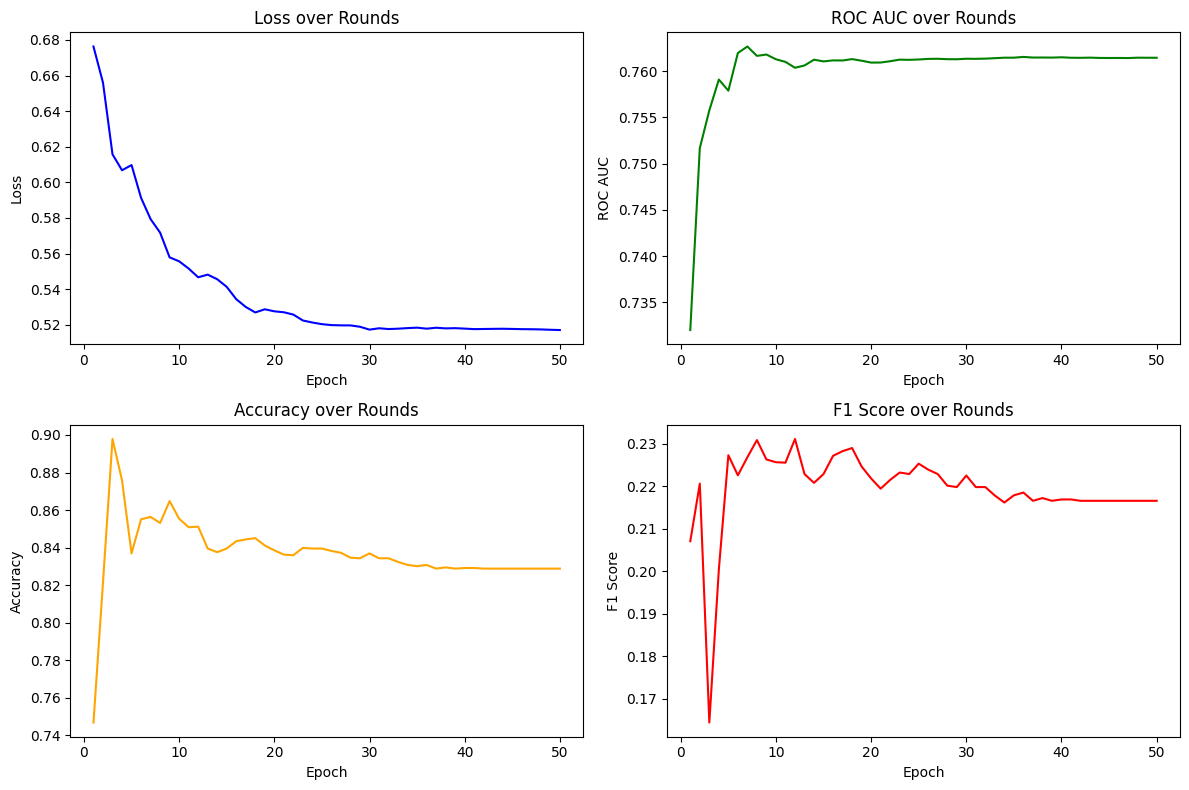

In [ ]:
L, ROC_AUC, ACCURACY, F1 = client.losses, client.ROC_AUCs, client.ACCURACYs, client.F1s
plot_metrics(L, ROC_AUC, ACCURACY, F1)

In [107]:
class CustomClient_Paillier(fl.client.NumPyClient):

        
    def __init__(self):

        super().__init__()
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []
    
        with open('../public_key.pkl', 'rb') as f:
            self.__public_key = pickle.load(f)

        with open('../private_key.pkl', 'rb') as f:
            self.__private_key = pickle.load(f)


    def get_parameters(self, config):

        print('================== INITIAL PARAMS ==================')
        params = ts.get_model_parameters(model)
        print(params)

        return params

    def fit(self, parameters, config):
        
        print('============================ PARAMS BEFORE  FIT===========================')
        print(parameters)
        
        ts.set_model_parameters(model, parameters)
                
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train_, y_train_)
        print(f"Training finished for round {config['server_round']}")
        print('============================= PARAMETERS AFTER FIT ===============================')
        params_1 = ts.get_model_parameters(model)
        print(f'clear: {params_1}')

        encrypted_params = [(self.__public_key.encrypt(value),) for param in params_1 for value in param.flatten()]
        enc_result = []
        index = 0

        for param in params_1:
                num_elements = param.size
                reshaped_array = np.array(encrypted_params[index:index + num_elements]).reshape(param.shape)
                enc_result.append(reshaped_array)
                index += num_elements
            # encrypt parameters here


        print(f'Encrypted: {enc_result}')
        
        return enc_result, len(X_train_), {}

    def evaluate(self, parameters, config):
        print('========================== evaluate PARAMS =============================================')
        # i got agg parameters for server, here i have to decrypt them
        print(parameters, parameters[0].size, parameters[1].size)
        decrypted_params = [(self.__private_key.decrypt(value),) for param in parameters for value in param.flatten()]
        dec_res = []
        index = 0
        for param in parameters:
               num_elements = param.size
               reshaped_array = np.array(decrypted_params[index:index + num_elements]).reshape(param.shape)
               dec_res.append(reshaped_array)
               index += num_elements
        print(f' Decrypted for EVAL {dec_res}')


        
        ts.set_model_parameters(model, dec_res)
        y_pred_proba = model.predict_proba(X_test_scale)[:, 1]
        y_pred = model.predict(X_test_scale)
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)
        
        
        parameters[0] = dec_res[0]
        parameters[1]  = dec_res[1]
        print('parameters after eval MUST BE DECRYPTED!')
        print(parameters)
        
        return loss, len(X_test), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}

if __name__ == "__main__":


    client_paillier = CustomClient_Paillier()
    model = LogisticRegression(
        penalty='l2',
        max_iter=5
    )

    ts.set_initial_parameters(model)

    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_paillier
    )

INFO :      
INFO :      Received: train message 8c777e43-0171-44c9-9cbe-d6121c2725f5


============================ PARAMS BEFORE  FIT===========================
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]]), array([0.])]
Training finished for round 1
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,
        -1.38609410e-02, -2.60335729e-01, -3.20981163e+00,
        -3.92069686e-02, -1.25521921e+00,  5.10087527e-01,
         2.43186867e-01, -8.53749399e-02,  2.94873751e-01,
        -1.46765590e-02,  1.64817614e-01,  2.90002917e-01,
        -4.52489529e-02, -8.52464143e-04, -3.59739149e-01,
        -1.10417339e-01, -2.13121441e-01,  5.10961452e-02,
         5.02200344e-02, -1.72290566e-03,  1.83540862e-01,
        -2.17192862e+00,  0.00000000e+00,

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001F52CFEF8B0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001F52CFEDED0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 8fdb51b6-a687-474f-8232-cbba5c368cf5


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001F52CFEDDE0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001F52CFCF670>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 04747e5e-ede8-44c8-adb1-72229ded4120


 Decrypted for EVAL [array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,
        -1.38609410e-02, -2.60335729e-01, -3.20981163e+00,
        -3.92069686e-02, -1.25521921e+00,  5.10087527e-01,
         2.43186867e-01, -8.53749399e-02,  2.94873751e-01,
        -1.46765590e-02,  1.64817614e-01,  2.90002917e-01,
        -4.52489529e-02, -8.52464143e-04, -3.59739149e-01,
        -1.10417339e-01, -2.13121441e-01,  5.10961452e-02,
         5.02200344e-02, -1.72290566e-03,  1.83540862e-01,
        -2.17192862e+00,  0.00000000e+00,  4.61243067e-01]]), array([0.32853188])]
accuracy: 0.6277561608300908
ROC_AUC: 0.7613598102234467
f1_score: 0.20608575380359612
parameters after eval MUST BE DECRYPTED!
[array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,


INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001F52CFEE020>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001F52CFCE8C0>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message f0d0da8f-80e3-4e01-8778-a79fba839466


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001F52CFCC2B0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001F52CFCCA30>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 73e61d4c-0a4c-48c7-9651-5450698aa640


 Decrypted for EVAL [array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,
        -1.38609410e-02, -2.60335729e-01, -3.20981163e+00,
        -3.92069686e-02, -1.25521921e+00,  5.10087527e-01,
         2.43186867e-01, -8.53749399e-02,  2.94873751e-01,
        -1.46765590e-02,  1.64817614e-01,  2.90002917e-01,
        -4.52489529e-02, -8.52464143e-04, -3.59739149e-01,
        -1.10417339e-01, -2.13121441e-01,  5.10961452e-02,
         5.02200344e-02, -1.72290566e-03,  1.83540862e-01,
        -2.17192862e+00,  0.00000000e+00,  4.61243067e-01]]), array([0.32853188])]
accuracy: 0.6277561608300908
ROC_AUC: 0.7613598102234467
f1_score: 0.20608575380359612
parameters after eval MUST BE DECRYPTED!
[array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,


INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000001F52CFCD8D0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001F52D014970>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 1cc676d0-d473-4e2f-b9a1-ac985ac39841


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000001F52CFCE920>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000001F52CFCC4C0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: reconnect message df6aec55-110c-41c0-9824-de079337d0ce


 Decrypted for EVAL [array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,
        -1.38609410e-02, -2.60335729e-01, -3.20981163e+00,
        -3.92069686e-02, -1.25521921e+00,  5.10087527e-01,
         2.43186867e-01, -8.53749399e-02,  2.94873751e-01,
        -1.46765590e-02,  1.64817614e-01,  2.90002917e-01,
        -4.52489529e-02, -8.52464143e-04, -3.59739149e-01,
        -1.10417339e-01, -2.13121441e-01,  5.10961452e-02,
         5.02200344e-02, -1.72290566e-03,  1.83540862e-01,
        -2.17192862e+00,  0.00000000e+00,  4.61243067e-01]]), array([0.32853188])]
accuracy: 0.6277561608300908
ROC_AUC: 0.7613598102234467
f1_score: 0.20608575380359612
parameters after eval MUST BE DECRYPTED!
[array([[-1.08964766e-01, -2.60385093e-01, -2.49177349e-01,
        -2.66330310e-01,  6.16474758e-02, -6.52442615e-02,
         2.71128277e-02, -2.95355228e-02,  6.55857249e-01,


INFO :      Disconnect and shut down


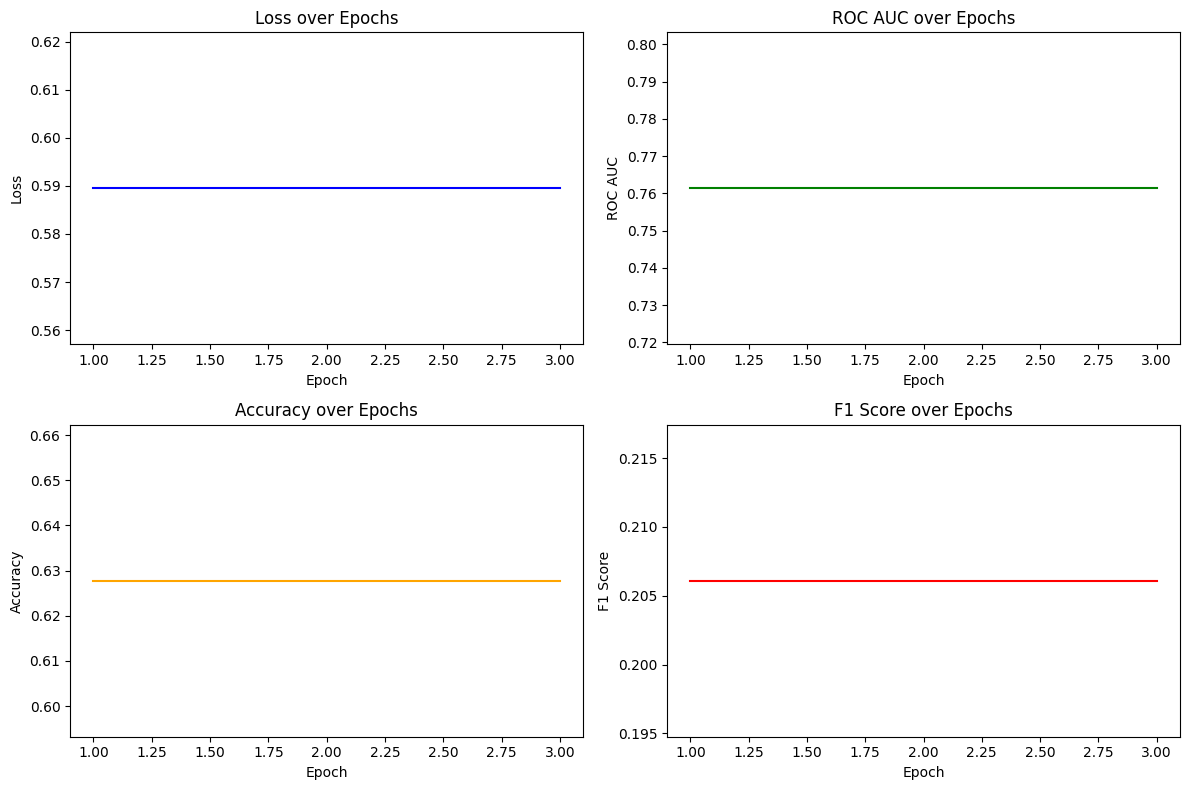

In [108]:
L, ROC_AUC, ACCURACY, F1 = client_paillier.losses, client_paillier.ROC_AUCs, client_paillier.ACCURACYs, client_paillier.F1s
plot_metrics(L, ROC_AUC, ACCURACY, F1)